In [ ]:
#부동산 가격 예측 실습 개요

#Who   : 부동산 가격 예측이 필요한 자
#When  : 2025.05.07
#Where : Python, VS Code
#What  : Kaggle "Real estate price prediction Dataset"
#       -> 단위 면적당 집 값(Y house price of unit area)을 예측하는 회귀 모델 개발
#Why   : 부동산 가격 결정 요인을 분석해 예측 정확도를 높이고, 의사결정 지원 및 시장 이해도를 향상시키기 위해
#How   : 1. 문제 정의
#        2. 데이터 및 라이브러리 불러오기
#        3. 데이터 확인하기
#        4. 데이터 전처리
#        5. 데이터 모델링 
#        6. 모델 적용(예측하기)
#        7. 예측 모델 평가
#        8. 모델 개선

##### 1. 문제 정의하기 -> PPT

##### 2.데이터 및 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import seaborn as sns
import sys

# 각 라이브러리의 버전 출력
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", matplotlib.__version__)
print("scikit-learn version:", sklearn.__version__)
print("seaborn version:", sns.__version__)

# 파이썬 버전 출력
print("Python version:", sys.version)

numpy version: 1.26.4
pandas version: 2.2.3
matplotlib version: 3.7.5
scikit-learn version: 1.2.2
seaborn version: 0.12.2
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction/Real estate.csv


In [3]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/kaggle/input/real-estate-price-prediction/Real estate.csv')

In [5]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [6]:
df.drop(columns=["No"], inplace=True)
print("index")

index


In [7]:
# 'X1 transaction date'를 연도, 월, 일로 분리
df['Year'] = df['X1 transaction date'].apply(lambda x: int(x))  # 연도
df['Month'] = df['X1 transaction date'].apply(lambda x: int((x - int(x)) * 12) + 1)  # 월 (0.250 -> 3월, 0.500 -> 6월)
df['Day'] = df['X1 transaction date'].apply(lambda x: int((x - int(x)) * 365.25 / 12))  # 일 (0.250 -> 약 8일, 0.500 -> 약 15일)

# 출력 확인
print(df)

     X1 transaction date  X2 house age  \
0               2012.917          32.0   
1               2012.917          19.5   
2               2013.583          13.3   
3               2013.500          13.3   
4               2012.833           5.0   
..                   ...           ...   
409             2013.000          13.7   
410             2012.667           5.6   
411             2013.250          18.8   
412             2013.000           8.1   
413             2013.500           6.5   

     X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                  84.87882                               10   
1                                 306.59470                                9   
2                                 561.98450                                5   
3                                 561.98450                                5   
4                                 390.56840                                5   
..             

In [8]:
# Day가 0이면 1로 바꿔주기
df['Day'] = df['Day'].replace(0, 1)

# Year, Month, Day를 datetime으로 변환
df['Transaction Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# 원래 Year, Month, Day 열 삭제
df.drop(columns=['Year', 'Month', 'Day', 'X1 transaction date'], inplace=True)

# 확인
print(df.head())

   X2 house age  X3 distance to the nearest MRT station  \
0          32.0                                84.87882   
1          19.5                               306.59470   
2          13.3                               561.98450   
3          13.3                               561.98450   
4           5.0                               390.56840   

   X4 number of convenience stores  X5 latitude  X6 longitude  \
0                               10     24.98298     121.54024   
1                                9     24.98034     121.53951   
2                                5     24.98746     121.54391   
3                                5     24.98746     121.54391   
4                                5     24.97937     121.54245   

   Y house price of unit area Transaction Date  
0                        37.9       2012-12-27  
1                        42.2       2012-12-27  
2                        47.3       2013-07-17  
3                        54.8       2013-07-15  
4        

In [9]:
# latitude와 longitude를 결합하여 새로운 변수 'Location' 생성
df['Location'] = np.sqrt((df['X5 latitude'] - df['X5 latitude'].mean())**2 + (df['X6 longitude'] - df['X6 longitude'].mean())**2)

# latitude와 longitude 열 삭제
df = df.drop(['X5 latitude', 'X6 longitude'], axis=1)

# 결과 확인
print(df)

     X2 house age  X3 distance to the nearest MRT station  \
0            32.0                                84.87882   
1            19.5                               306.59470   
2            13.3                               561.98450   
3            13.3                               561.98450   
4             5.0                               390.56840   
..            ...                                     ...   
409          13.7                              4082.01500   
410           5.6                                90.45606   
411          18.8                               390.96960   
412           8.1                               104.81010   
413           6.5                                90.45606   

     X4 number of convenience stores  Y house price of unit area  \
0                                 10                        37.9   
1                                  9                        42.2   
2                                  5                        47.

In [10]:
df.shape

(414, 6)

특성 5개, 타겟 1개

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   X2 house age                            414 non-null    float64       
 1   X3 distance to the nearest MRT station  414 non-null    float64       
 2   X4 number of convenience stores         414 non-null    int64         
 3   Y house price of unit area              414 non-null    float64       
 4   Transaction Date                        414 non-null    datetime64[ns]
 5   Location                                414 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 19.5 KB


In [12]:
df.isnull().sum()

X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
Y house price of unit area                0
Transaction Date                          0
Location                                  0
dtype: int64

* Null 값이 없는 아름다운 데이터이다

In [13]:
df.duplicated().sum()

0

* 중복치가 없는 아름다운 데이터이다

In [14]:
df.nunique()

X2 house age                              236
X3 distance to the nearest MRT station    259
X4 number of convenience stores            11
Y house price of unit area                270
Transaction Date                           12
Location                                  259
dtype: int64

수치형 : 연속형 X2, X3, Y house price of unit area, Location// 이산형 : X4, Transaction Date

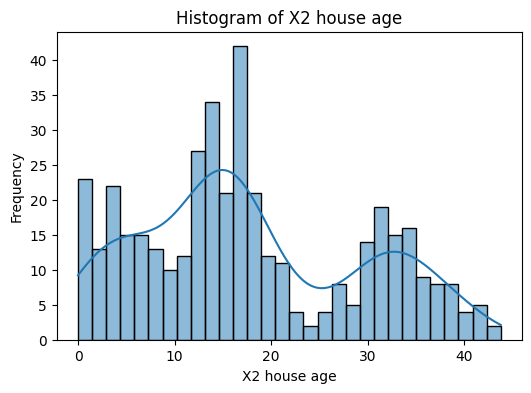

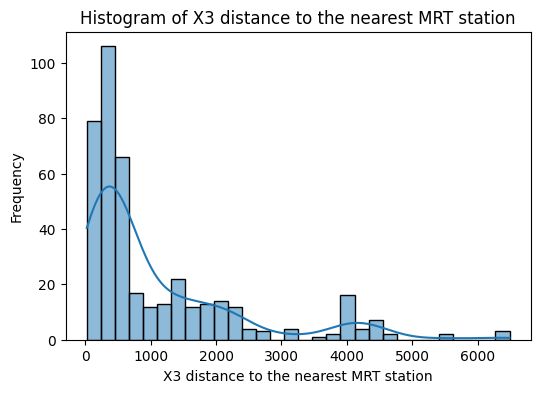

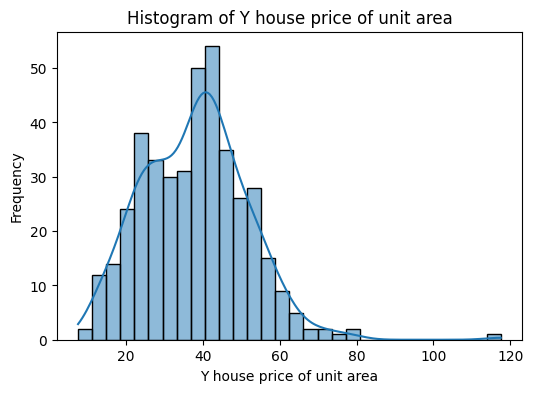

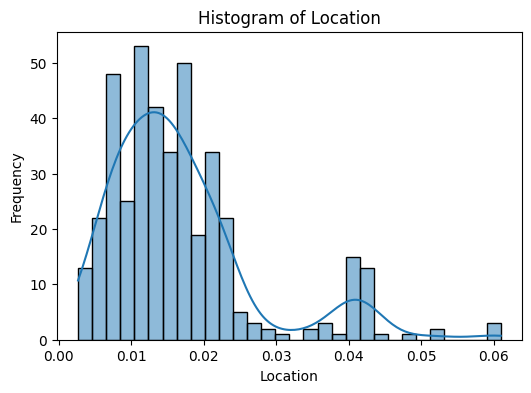

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

continuous_cols = [
    "X2 house age",
    "X3 distance to the nearest MRT station",
    "Y house price of unit area",
    "Location"
]

for col in continuous_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

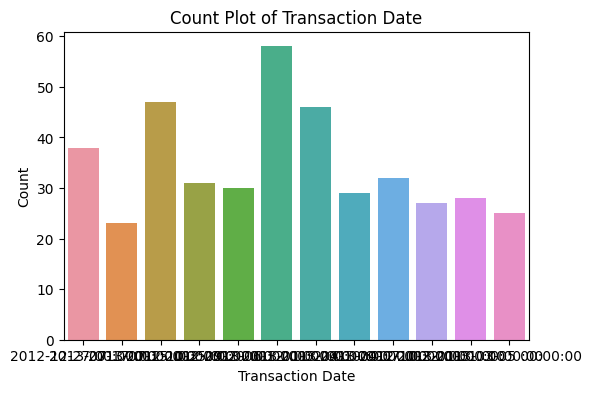

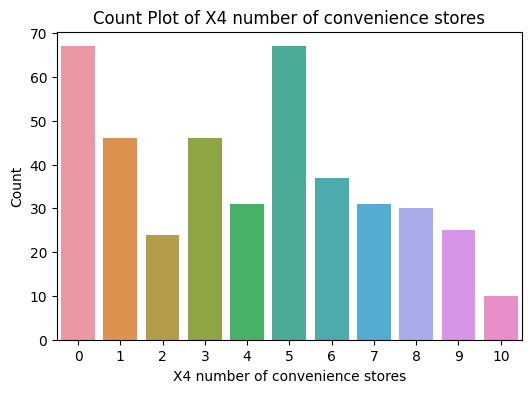

In [16]:
categorical_cols = [
    "Transaction Date",
    "X4 number of convenience stores",
]

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks()  # 글자 겹침 방지
    plt.show()

In [17]:
df["Transaction Date"].unique()

<DatetimeArray>
['2012-12-27 00:00:00', '2013-07-17 00:00:00', '2013-07-15 00:00:00',
 '2012-10-25 00:00:00', '2012-09-20 00:00:00', '2013-06-12 00:00:00',
 '2013-01-02 00:00:00', '2013-04-10 00:00:00', '2013-04-07 00:00:00',
 '2012-10-22 00:00:00', '2013-01-01 00:00:00', '2013-03-05 00:00:00']
Length: 12, dtype: datetime64[ns]

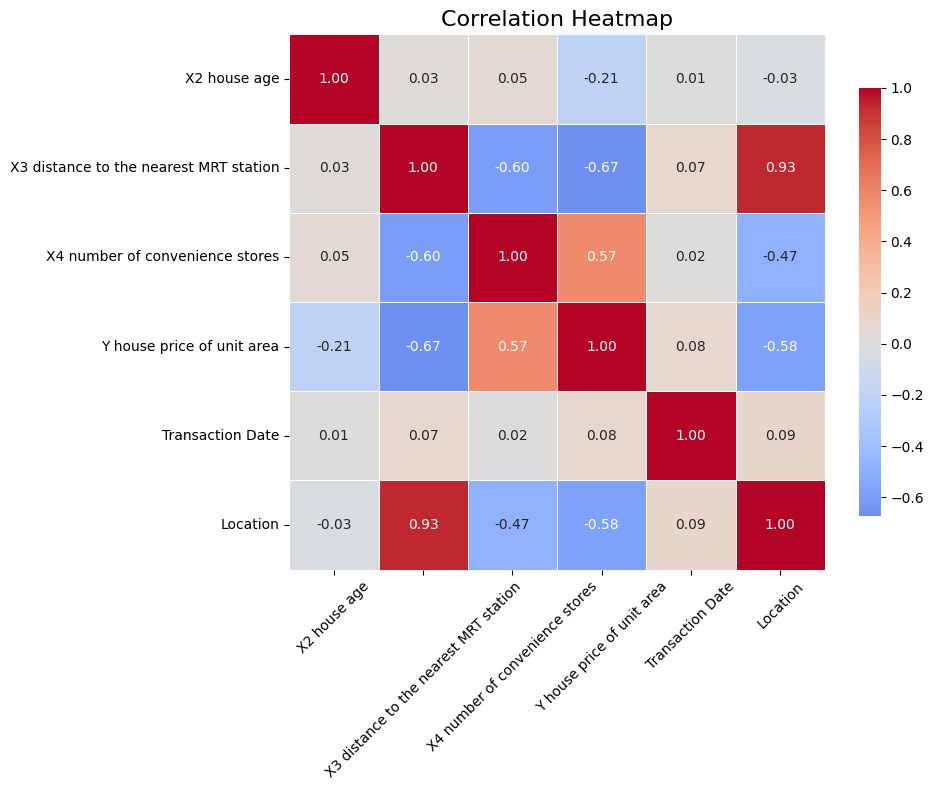

In [18]:
# 상관관계 행렬 계산
corr_matrix = df.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

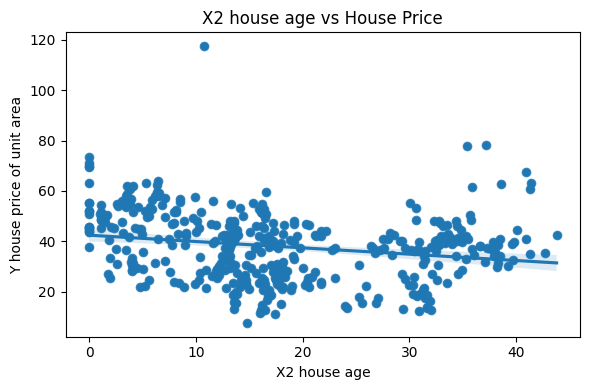

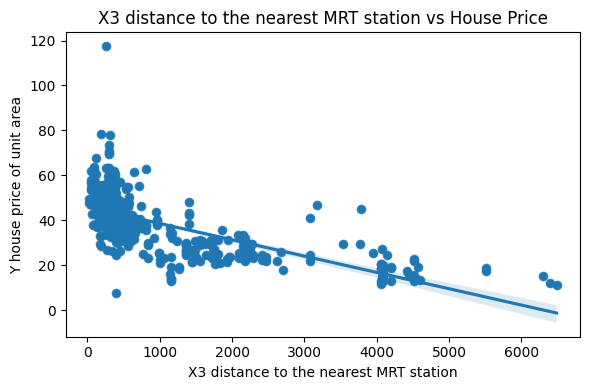

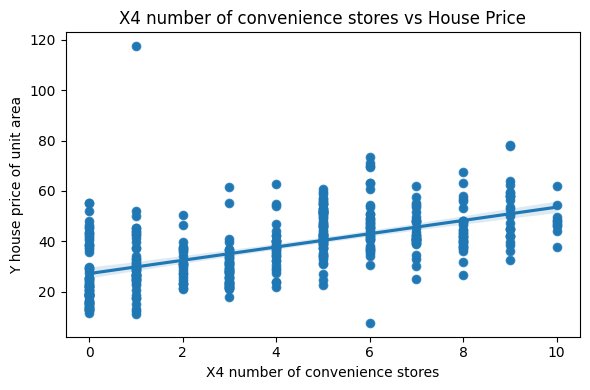

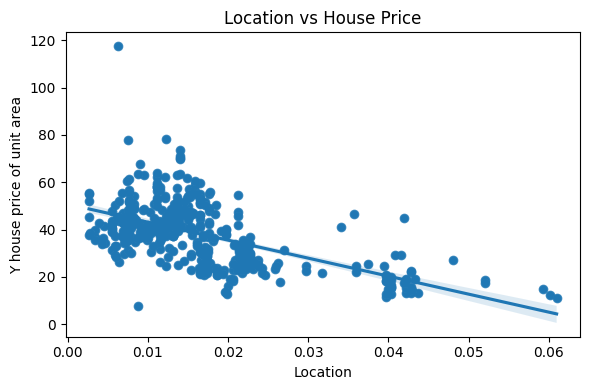

In [19]:
numeric_features = df.select_dtypes(include='number').columns.drop('Y house price of unit area')

for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df['Y house price of unit area'])
    plt.title(f'{col} vs House Price')
    plt.xlabel(col)
    plt.ylabel('House Price per Unit Area')
    plt.tight_layout()
    sns.regplot(x=df[col], y=df['Y house price of unit area'])
    plt.show()
    

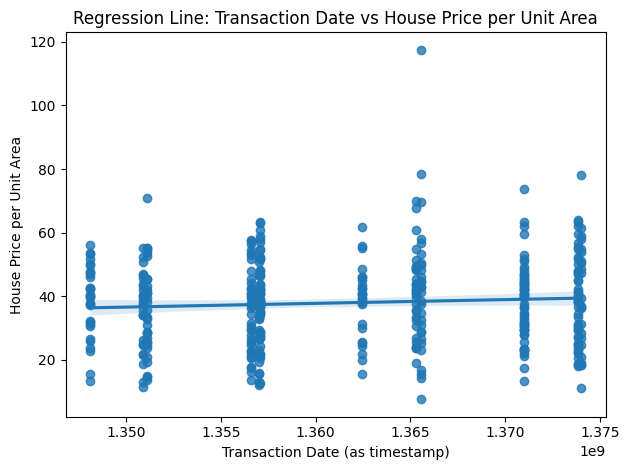

In [20]:
# 'date_time'을 timestamp로 변환
df['DateTime_Stamp'] = df['Transaction Date'].astype(int) / 10**9  # 초 단위 timestamp로 변환

# 회귀선이 포함된 산점도
sns.regplot(x=df['DateTime_Stamp'], y=df['Y house price of unit area'])
plt.title('Regression Line: Transaction Date vs House Price per Unit Area')
plt.xlabel('Transaction Date (as timestamp)')
plt.ylabel('House Price per Unit Area')
plt.tight_layout()
plt.show()

In [21]:
numeric_features = df.select_dtypes(include=['number']).columns

df_adjusted = df.copy()
df_adjusted[numeric_features] = df[numeric_features] + 1  # 수치형 열에만 +1 추가

# PowerTransformer 초기화 (Box-Cox 변환)
scaler = PowerTransformer(method='box-cox')

# 박스-콕스 변환을 적용할 수 있는 수치형 열 선택
df_transformed = df_adjusted.copy()
df_transformed[numeric_features] = scaler.fit_transform(df_adjusted[numeric_features])

# 변환된 데이터 출력
print(df_transformed)

     X2 house age  X3 distance to the nearest MRT station  \
0        1.182955                               -1.768004   
1        0.288757                               -0.589288   
2       -0.241865                               -0.042591   
3       -0.241865                               -0.042591   
4       -1.147002                               -0.370084   
..            ...                                     ...   
409     -0.205009                                1.697912   
410     -1.068366                               -1.709073   
411      0.232628                               -0.369157   
412     -0.769091                               -1.572852   
413     -0.955865                               -1.709073   

     X4 number of convenience stores  Y house price of unit area  \
0                           1.718527                    0.069473   
1                           1.480492                    0.376490   
2                           0.410903                    0.72433

In [22]:
scaler = StandardScaler()

# 스탠다드 스케일러 적용
df_scaled = df_transformed.copy()
df_scaled[numeric_features] = scaler.fit_transform(df_scaled[numeric_features])

# 변환된 데이터 출력
print(df_scaled)

     X2 house age  X3 distance to the nearest MRT station  \
0        1.182955                               -1.768004   
1        0.288757                               -0.589288   
2       -0.241865                               -0.042591   
3       -0.241865                               -0.042591   
4       -1.147002                               -0.370084   
..            ...                                     ...   
409     -0.205009                                1.697912   
410     -1.068366                               -1.709073   
411      0.232628                               -0.369157   
412     -0.769091                               -1.572852   
413     -0.955865                               -1.709073   

     X4 number of convenience stores  Y house price of unit area  \
0                           1.718527                    0.069473   
1                           1.480492                    0.376490   
2                           0.410903                    0.72433

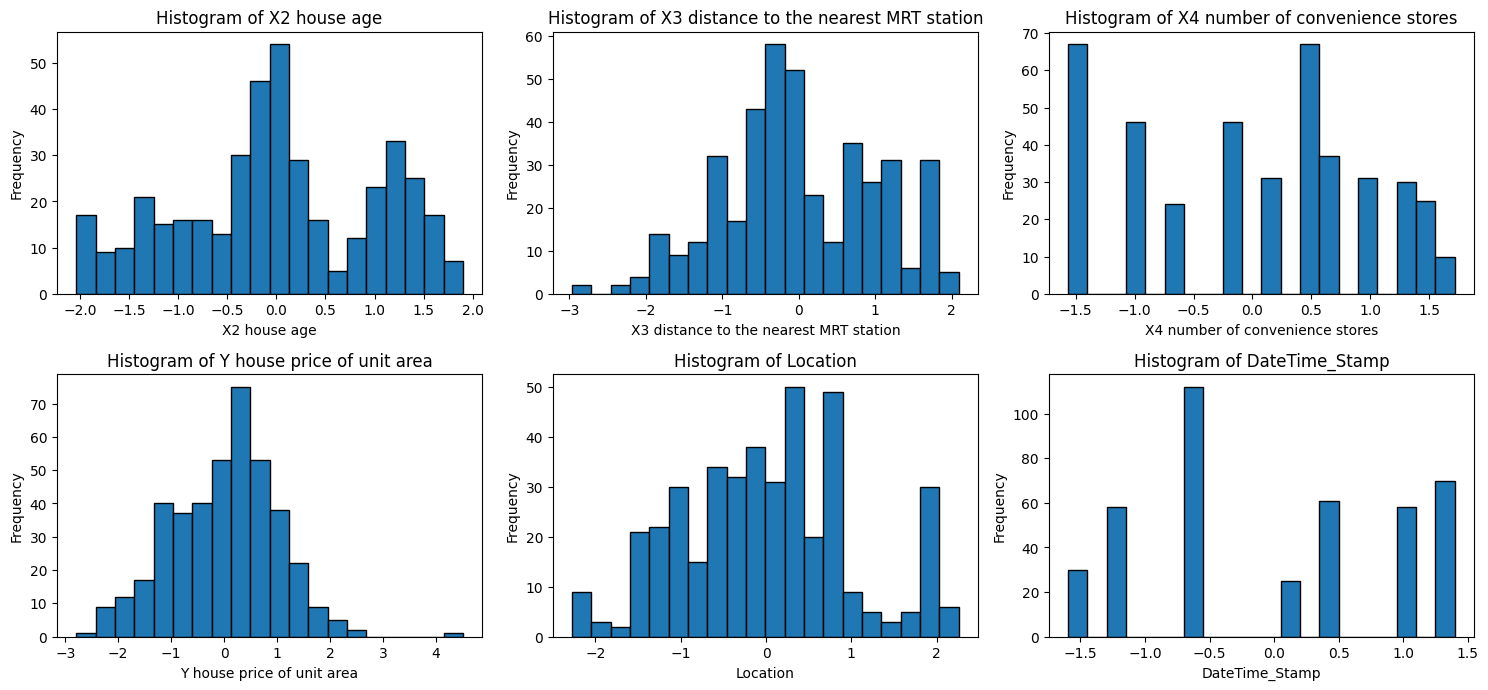

In [23]:
numeric_features = df_scaled.select_dtypes(include=['number']).columns

# 히스토그램 그리기
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)  # 3x3 grid for subplots
    plt.hist(df_scaled[col], bins=20, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [24]:
df_scaled = df_scaled.drop(columns=['Transaction Date'])

# 특성과 타겟 변수를 나눕니다.
X = df_scaled.drop(columns=['Y house price of unit area'])
y = df_scaled['Y house price of unit area']

# 훈련 세트와 테스트 세트로 데이터를 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 초기화
model = LinearRegression()

# 모델 훈련
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

In [25]:
# 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 결과 출력
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² (결정계수): {r2}")

Mean Squared Error (MSE): 0.2879962531358794
Root Mean Squared Error (RMSE): 0.5366528236540635
Mean Absolute Error (MAE): 0.3751389715252231
R² (결정계수): 0.7078865553577673


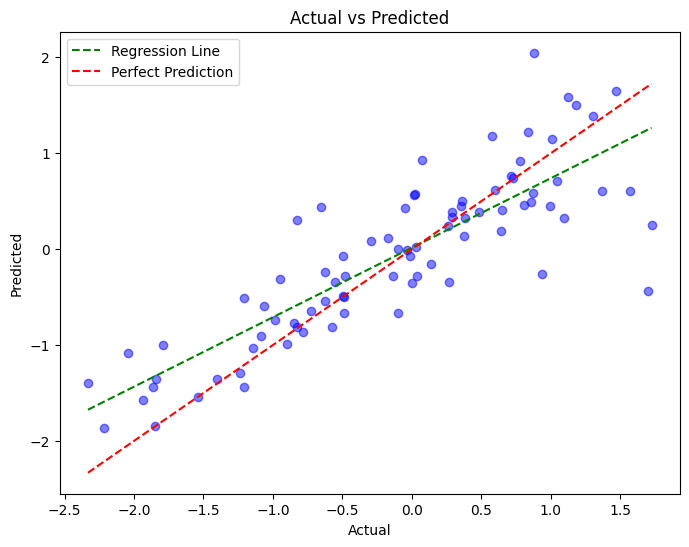

In [26]:
# 실제값 vs 예측값 시각화
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

# 회귀선 추가
slope, intercept = np.polyfit(y_test, y_pred, 1)
plt.plot([min(y_test), max(y_test)], [slope * min(y_test) + intercept, slope * max(y_test) + intercept], color='green', linestyle='--', label="Regression Line")

# 실제값 = 예측값 선
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction")

# 제목, 레이블 추가
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

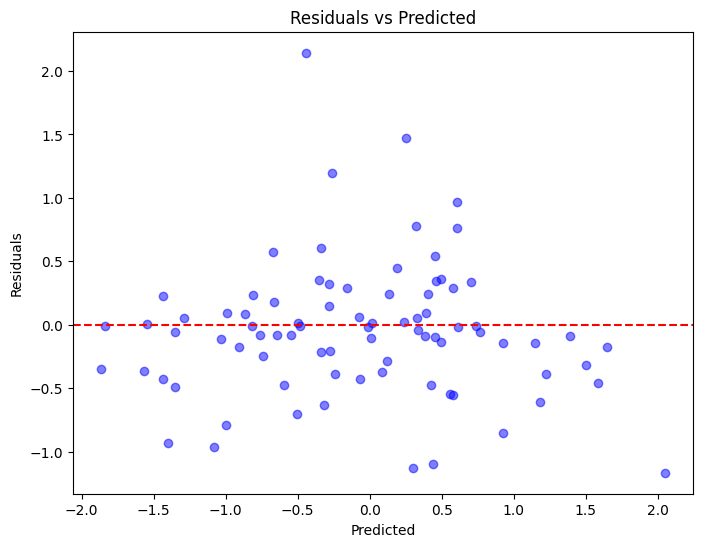

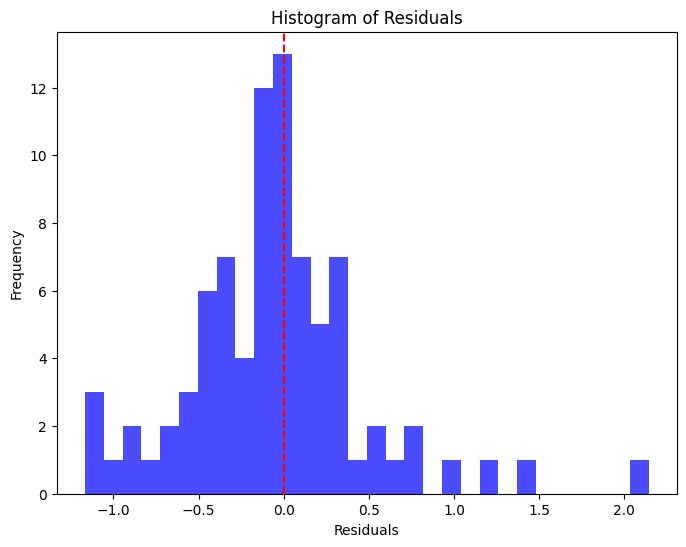

In [27]:
# 잔차(실제값 - 예측값)
residuals = y_test - y_pred

# 잔차 시각화 (Residuals vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

# 잔차의 히스토그램 추가
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()